<a href="https://colab.research.google.com/github/zfukuoka/image_visual_analysis/blob/createLabView/image_visual_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Analysis in comparing using Gooogle Colab / Google Colaboratory用画像比較分析

This is image analysis in comparing using Google Colab.
Now, this program compares CIE 1931 xy color space between 2 images.

Google Colaboratory用の画像比較分析プログラムです。
現在は、CIE xy色度図の比較表示に特化しています。

## Requirement / 動作に必要なもの

*   Google account for use of Google Colab / Google Colaboratory を使うための Google アカウント
*   Web browther / Webブラウザ
*   2 pictures have same angle of view / 同じ画角で撮影した画像２枚

## Striction / 制限事項

* 簡単に動かし、プロット（結果）を重視していますが、結果の表示はPC上で見ることを想定しています
  * Android上のChromeでも動くようファイルのアップロード処理を1つずつにできるように改善しましたが、プロットの表示を横2枚に並べた時に見づらいままになっています
* sRGBの色空間とガンマ2.2を採用したのJPEGファイルのみ正しく動作します
  *  最近のiPhoneはDisplayP3の色空間のため、正しく動作しません
  * ガンマ値は2.2に固定して、ガンマ補正を外してリニアなRGB化処理
  * 処理そのものでJPEGのみには制限しておりませんが、正しく動作しない可能性があります
* 画像サイズが大きいと、アップロード時間が増大します
  * 後述のとおり、アップロードした画像の間引きをする処理が行われているので、あらかじめ画質を落とさず、解像度を低くしてファイルサイズを抑制した画像を利用することをお勧めします。
* 一度アップロードした画像ファイルでも再度アップロードが必要です
  * 何百回も使い続けると、画像をアップロードによるGoogle Colaboratory上のストレージを圧迫する可能性があります
  * Google Colaboratory上のストレージの圧迫を危惧するような事態になった場合、一旦セッション（Google Colaboratory上の動作環境）を終了してから、再度起動してください。現行の振る舞いでは終了でストレージの中身が消えるようです
* 変換する画像からピクセルの間引きを行ったあとに色変換の処理をします
  * 間引きはリサイズによる色の変化（画像にない色を作られること）を避けるために行っており、より良い方法があったときには間引きから変わることがあります
  * プロット時に全体がつぶれすぎない位の経験則から長編256ドット未満になるようにしています
* 処理の基本的なところはGoogle Colaboratory に依存していません
  * Python環境を新規に構築することなく簡単に使えるようにしたかったので画像ファイルのアップロード部分のみ Google Colaboratory に依存した作りです
*   わかりやすいグラフの完成系が見えていないため、冗長なコードがあったり、逐次コード変更する可能性があります
  * この結果、matplotlibの使い方におかしなところがあったりします
* 入力した画像を表示する機能は一時的な実装で、まともな機能にする予定もなく、将来削除する可能性があります
  * EXIFの情報などの参照なしでランドスケープで表示しているため、左右や上下の反転があります
* Pythonのコードは依存関係を少なくなるようにした結果、本コード内に多くの処理を記載しているので、長くて見づらいところがあります
  * 見やすさの改善は今後も検討課題ですが、現時点ではあまり重視しておりません
  * 現コードの半分近くは、プロット関係のコードで占めております
  * データを変換（色の変換）する処理は、 別のところでの開発経験での処理速度の関係から、numpyに特化した書き方に努めているため、一見したときの可読性が低いです
 
## How to use / 動作方法

This jupyter notebook has only 1 cell. So, it runs the cell and uploads 2 pictures which have same angle of view.
When upload error is occurred in specifing 2 pictures at once, please specify and upload pictures one by one.  

唯一のセルを起動後（わからなければ、メニューの「ランタイム」→「すべてのセルを実行」）、コードの後ろにある実行結果を表示ところでファイルアップロードが求められるので、２つ画像ファイルを指定して、後は待つだけ。
もし画像２つを同時指定してアップロードに失敗するようなら、一つずつ画像の指定とアップロードをしてください。

## Details / 詳細な仕様

### Gamma correction / ガンマ補正

本プログラムでは sRGB の ガンマ補正がかかった画像を前提としている。
このため、一旦ガンマ補正がかかった（非線形）なRGB値から逆補正してリニア（線形）なRGB値を利用している。

この時の逆補正には下記の計算式を用いている。

$$
f(t) = 
  \begin{cases}
  \begin{align}
    & \biggl( \frac{t + 0.055}{1.055} \biggr) ^{2.4} & t > 0.04045 \\
    & \frac{t}{12.92} & t \leqq 0.04045 \\
  \end{align}
  \end{cases}
$$

t は RGB各々を 0 ～ 1に収まるように正規化した値とする。

### Luminance / 輝度

本プログラムでは、輝度の算出に ITU-R BT.601 に従った下記の計算式でRGB値から算出している

$$
L = 0.299R + 0.587G + 0.114B
$$

R/G/B のいずれも 0 ～ 1 に収まるように正規化した値とする。

Saving st52693_tabijo-04_EX.jpg to st52693_tabijo-04_EX (2).jpg
Saving st52693_tabijo-04lite_EX.jpg to st52693_tabijo-04lite_EX (2).jpg
(590, 442) RGB
(590, 442) RGB


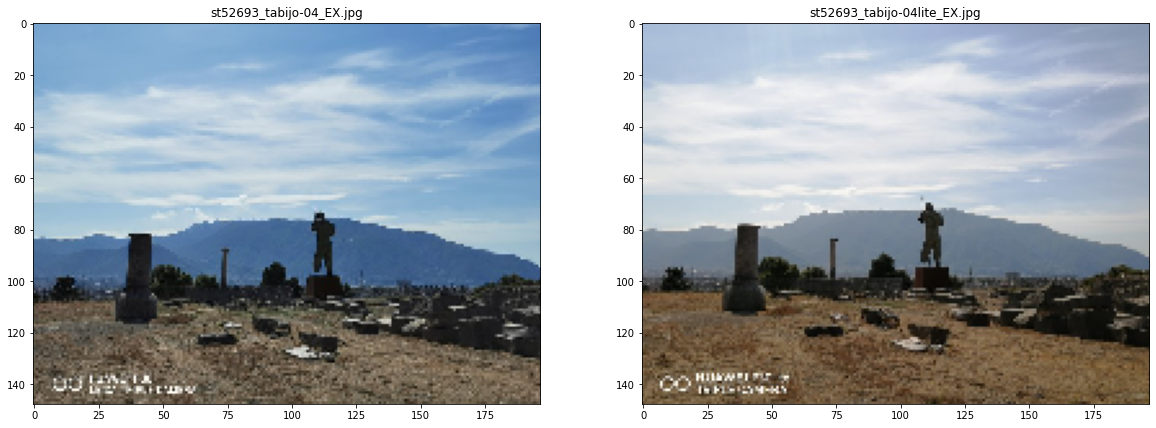

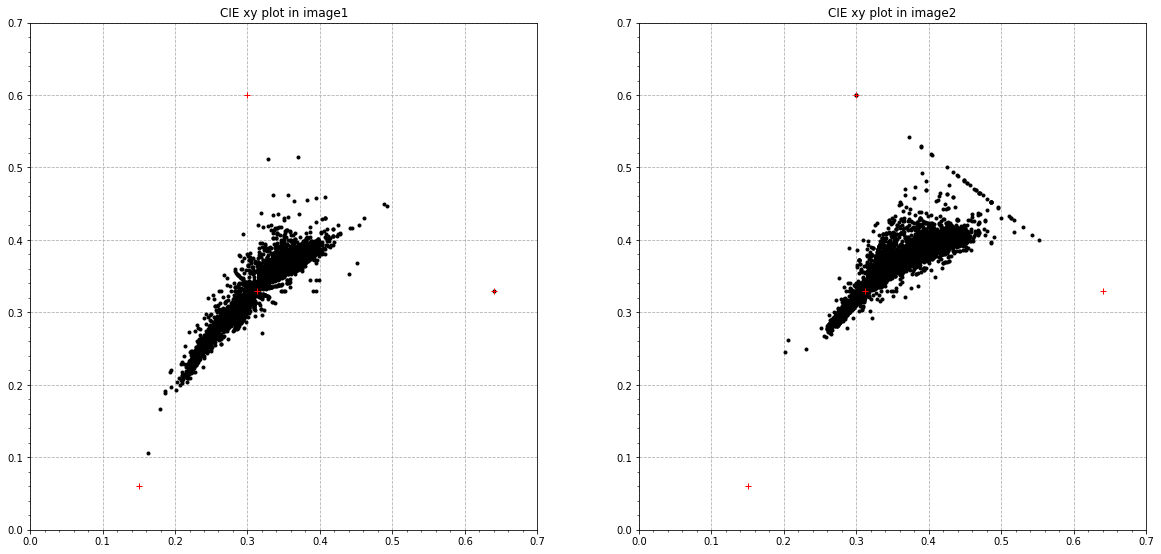

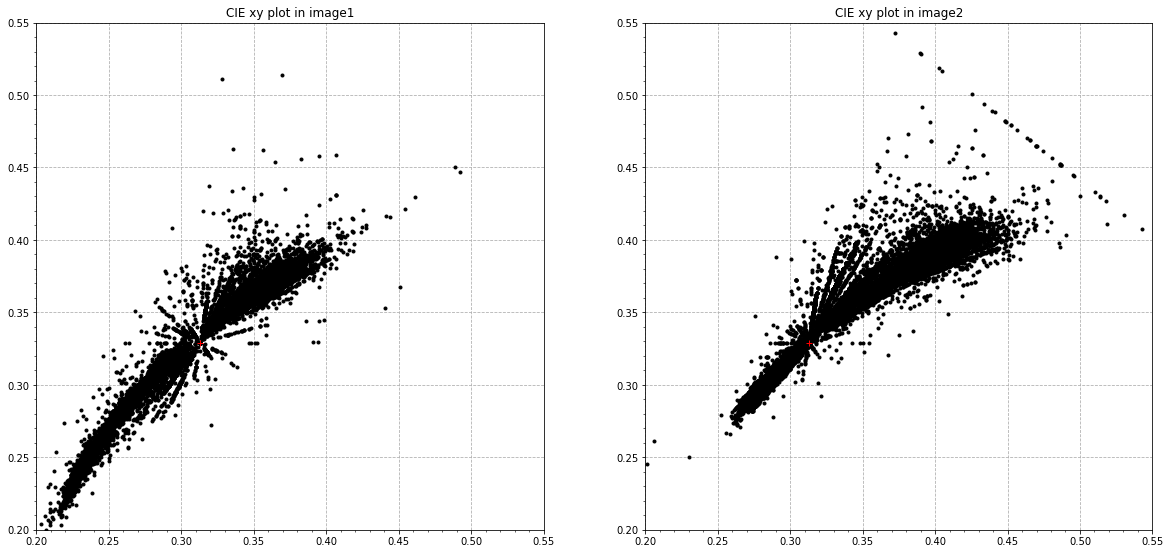

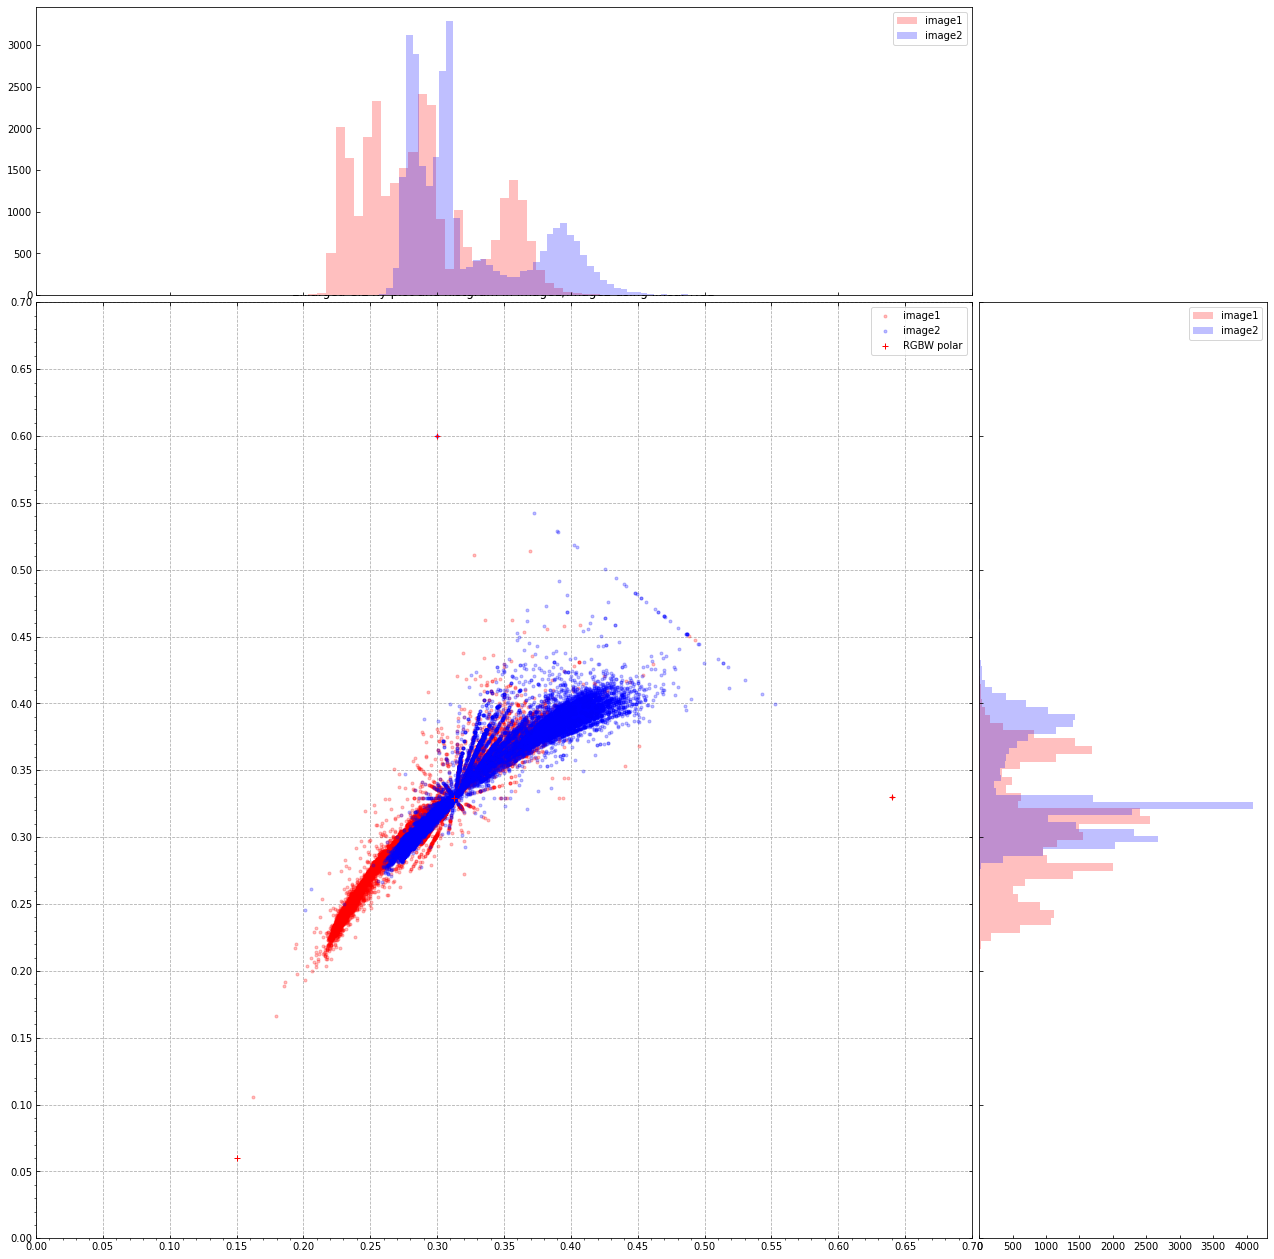

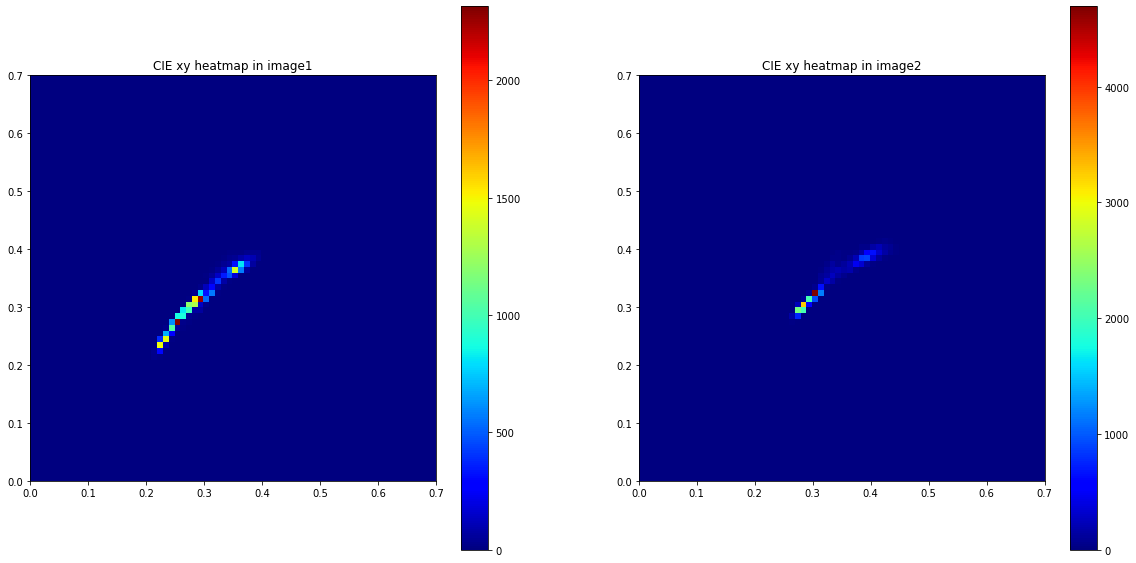

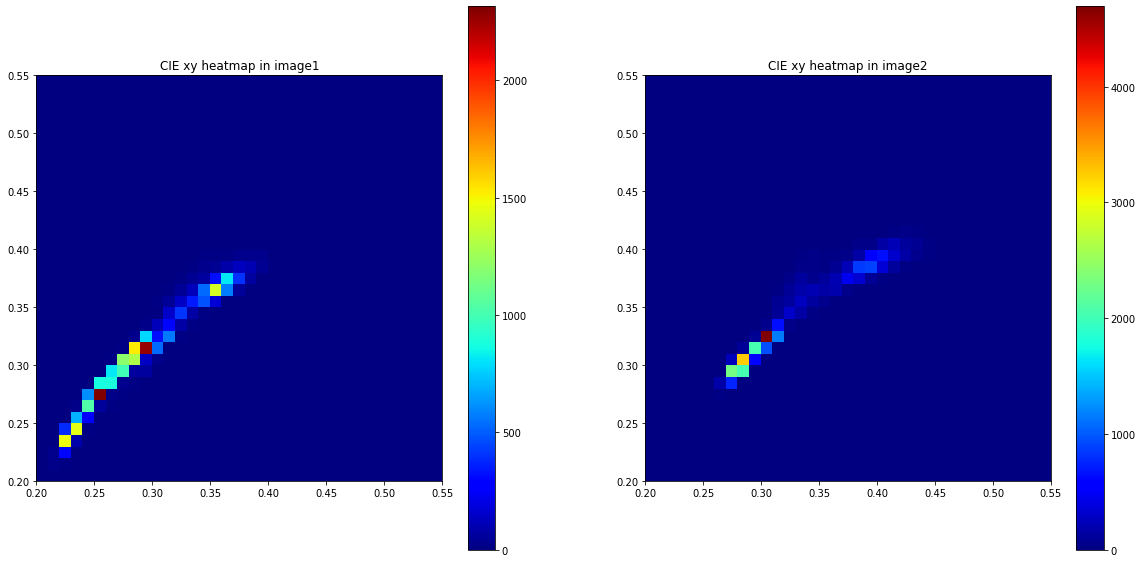

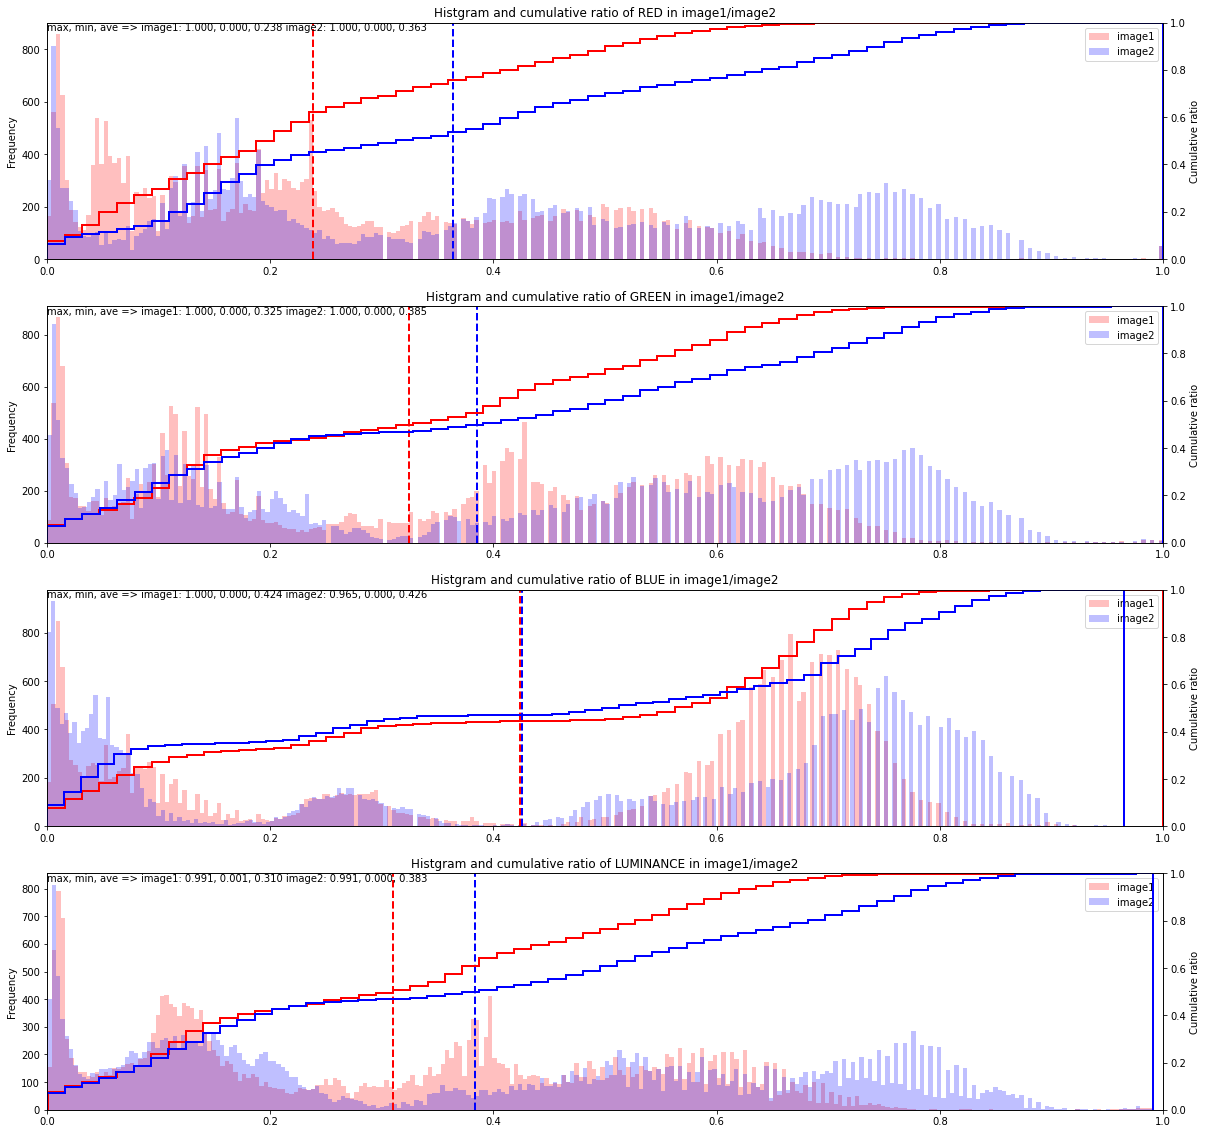

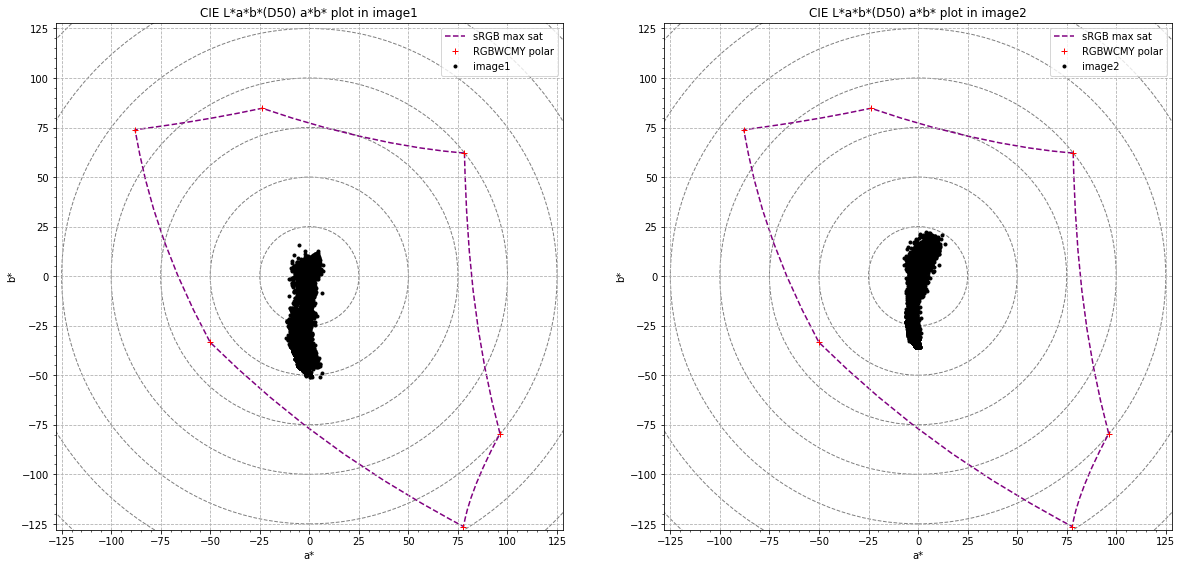

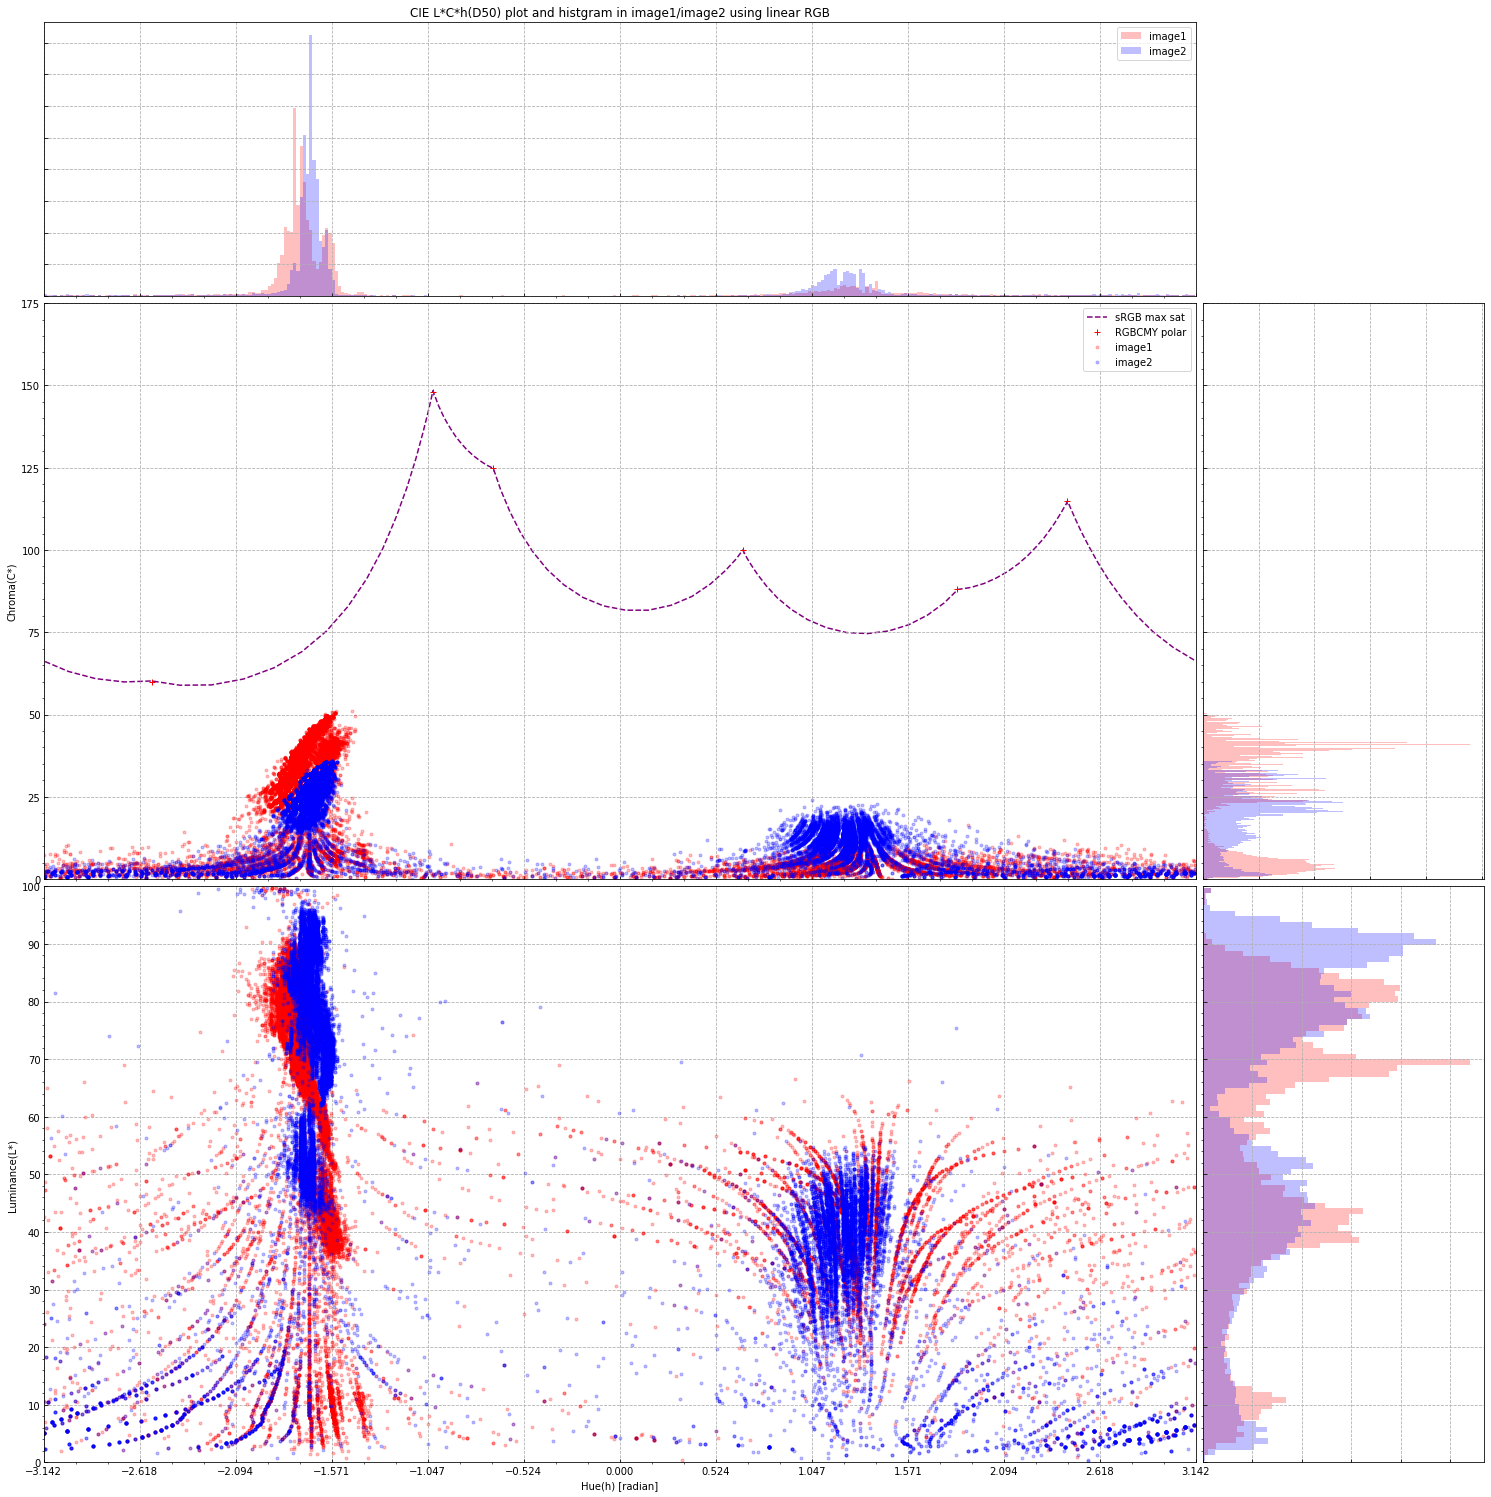

In [4]:
# -*- coding: utf-8 -*-

# import libraries
from google.colab import files
import io
from matplotlib import cm as cm
from matplotlib import patches as patches
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import numpy as np
from PIL import Image
import sys

### 複数個所で使われる定数 
DEFAULT_DTYPE = np.float32              # numpyで用いる型

## 全プロット共通の定義 ... スマホ向けにしようとした場合、他の部分も変更が必要
PLOT_AREA_LANDSCAPE = (20, 10)  # プロット領域横長
PLOT_AREA_SQUARE = (20, 20)     # プロット領域正方
MIX_TRANSPARENT_RATE = 0.25      # 重ね合わせのあるプロットなどでの透過率

## CIE xyに特化したパラメータ
CIEXY_RGBW_POLARS = np.array(
    [[0.64, 0.33], [0.30, 0.60], [0.15, 0.06], [0.3127, 0.3290]]
) # CIX xyプロット上で固定でプロットする座標(sRGB色空間のR,G,B,Wの極値)

## CIE xyプロットの表現範囲及びプロット周りの設定
CIEXY_PLOT_X_LIM = (0, 0.7)             # sRGB全体をカバーするX軸の下限、上限
CIEXY_PLOT_Y_LIM = (0, 0.7)             # sRGB全体をカバーするY軸の下限、上限
CIEXY_CROPPED_PLOT_X_LIM = (0.2, 0.55)  # 主な光源色をカバーするX軸の下限、上限
CIEXY_CROPPED_PLOT_Y_LIM = (0.2, 0.55)  # 主な光源色をカバーするY軸の下限、上限
CIEXY_MAJOR_LOCATOR = 0.1               # ガイド付きのメモリ間隔
CIEXY_CROPPED_MAJOR_LOCATOR = CIEXY_MAJOR_LOCATOR / 2 # ガイド付きのメモリ間隔
CIEXY_MINOR_LOCATOR_DIVIDER = 5         # ガイド付きのメモリ間隔の小メモリの分割数
CIEXY_HIST_BINS = 70                    # ヒストグラムの分割数、現状プロット表現範囲0～0.7に合わせて0.01の粒度で分割
CIEXY_GRID_LINESTYLE = "--"             # CIE xyプロットのグリッド線の形状
CIEXY_PLOT_MARKER = '.'                 # CIE xyプロットのプロットマーカー形状
CIEXY_PLOT_LINESTYLE = ''               # CIE xyプロットのプロット間の線の形状
CIEXY_PLOT_POLAR_COLOR = 'red'          # sRGBの極値のプロット色
CIEXY_PLOT_POLAR_MARKER = '+'           # sRGBの極値のプロットマーカー形状
CIEXY_PLOT_POLAR_LINESTYLE = ''         # sRGBの極値間の線の形状（表示しない）

## CIE Labに特化したパラメータ
CIEAB_RGBWCMY_POLARS = np.array(
    [[78.3, 62.2], [-88.0, 73.9], [77.8, -126.4], [-2.4, -19.4],
     [-50.1, -33.4], [96.2, -79.5], [-23.8, 84.7]]
) # CIE abプロット上で固定でプロットする座標(sRGB色空間のR,G,B,W,M,C,Yの極値)
CIEHC_RGBCMY_POLARS = np.array(
    [[0.67, 100], [2.44, 115], [-1.02, 148],
     [-2.55, 60], [-0.69, 125], [1.84, 88]]
) # CIE HCプロット上で固定でプロットする座標(sRGB色空間のR,G,B,M,C,Yの極値)

## CIE Labプロットの表現範囲及びプロット周りの設定
CIEAB_PLOT_A_LIM = (-128, 128)
CIEAB_PLOT_B_LIM = (-128, 128)
CIEAB_MAJOR_LOCATOR = 25
CIEAB_PLOT_MARKER = '.'                 # CIE abプロットのプロットマーカー形状
CIEAB_PLOT_LINESTYLE = ''               # CIE abプロットのプロット間の線の形状
CIELCH_PLOT_MARKER = '.'                # CIE LChプロットのプロットマーカー形状
CIELCH_PLOT_LINESTYLE = ''              # CIE LChプロットのプロット間の線の形状
CIEH_HIST_BINS = 360                    # Hヒストグラムの分割数(1度単位)
CIEL_HIST_BINS = 100                    # Lヒストグラムの分割数
CIEC_HIST_BINS = 175                    # Cヒストグラムの分割数(sRGBのBの最大彩度)
CIELABLCH_PLOT_SRGB_POLAR_COLOR = 'red' # sRGBの極値のプロット色
CIELABLCH_PLOT_SRGB_POLAR_MARKER = '+'  # sRGBの極値のプロットマーカー形状
CIELABLCH_PLOT_SRGB_POLAR_LINESTYLE = ''# sRGBの極値間の線の形状（表示しない）
CIELABLCH_PLOT_SRGB_MAX_SAT_COLOR = '#800080'  # sRGBの最大彩度のプロット色
CIELABLCH_PLOT_SRGB_MAX_SAT_LINESTYLE = '--'  # sRGBの最大彩度のプロット色

# 輝度ヒストグラムのパラメータ
RGB2Y_CONVERT_MATRIX = np.array([0.299, 0.587, 0.114]) # ITU-R BT.601 に従った輝度Yの変換行列

## プロットで画像毎にループするときに用いる定数（現状2つの画像まで）
IMAGE1_COLOR = 'red'
IMAGE2_COLOR = 'blue'
COLORS = [IMAGE1_COLOR, IMAGE2_COLOR]
LOOP_MAX = len(COLORS)


def main():

  ## Google Colabに特化した画像読み込み
  # 一括で2つ画像指定と分割で1つずつ画像指定に対応
  # 3つ以上や0個などは強制終了
  uploaded_images = files.upload()

  if(len(uploaded_images) == 1):
    uploaded_images2 = files.upload()
    if(len(uploaded_images2) != 1):
      print("This program require 2 image files. So, please retry again.")
      sys.exit(1)
    else:
      uploaded_images.update(uploaded_images2)
  elif(len(uploaded_images) != 2):
    print("This program requires 2 image files. So, please retry again.")
    print(uploaded_images.keys())
    sys.exit(1)

  ims = list()
  im_fnames = list()
  for k, v in uploaded_images.items():
    img_bin = io.BytesIO(v)
    ims.append(Image.open(img_bin))
    im_fnames.append(k)

  # 画像データの前処理
  ciexyzs = list()
  normalizedRGBs = list()
  reducedImages = list()
  cielabs = list()
  cielchs = list()
  for im in ims:
    print(im.size, im.mode)
    im_list = np.asarray(im)

    # 画像の間引き：長編を256未満にする間引き
    MAX_IMG_WIDTH = 256
    (img_x, img_y, img_dim) = im_list.shape
    if img_x  > img_y:
      skip = int(img_x / MAX_IMG_WIDTH) + 1
      im_list2 = im_list[::skip,::skip,::]
      reducedImages.append(np.transpose(im_list2, axes=(1,0,2)))
    else:
      skip = int(img_y / MAX_IMG_WIDTH) + 1
      im_list2 = im_list[::skip,::skip,::]
      reducedImages.append(im_list2)

    # RGB to CIE xyz
    normalizedRGB = normalizeLinearRgb(im_list2)
    normalizedRGBs.append(normalizedRGB)
    cieXYZ = convertToCieXYZ(normalizedRGB)
    ciexyzs.append(convertToCiexyz(cieXYZ))
    cielabs.append(convertToCielab(cieXYZ))
    cielchs.append(convertToCielch(cielabs[-1]))

  # プロット用にCIE xyとRGBLのデータ抽出
  image_x = list()
  image_y = list()
  image_a = list()
  image_b = list()
  image_l = list()
  image_c = list()
  image_h = list()

  for i in range(LOOP_MAX):
    image_x.append(ciexyzs[i][0:, 0])
    image_y.append(ciexyzs[i][0:, 1])
    image_a.append(cielabs[i][0:, 1])
    image_b.append(cielabs[i][0:, 2])
    image_l.append(cielchs[i][0:, 0])
    image_c.append(cielchs[i][0:, 1])
    image_h.append(cielchs[i][0:, 2])
  
  temp = normalizedRGBs[0].reshape(-1, 3)
  image1_r = temp[0:, 0]
  image1_g = temp[0:, 1]
  image1_b = temp[0:, 2]
  image1_l = np.dot(temp[0:,], RGB2Y_CONVERT_MATRIX)
  temp = normalizedRGBs[1].reshape(-1, 3)
  image2_r = temp[0:, 0]
  image2_g = temp[0:, 1]
  image2_b = temp[0:, 2]
  image2_l = np.dot(temp[0:,], RGB2Y_CONVERT_MATRIX)

  # 画像表示
  plotImage(reducedImages, im_fnames)

  # プロット1 CIE xyのプロット、画像毎にプロット
  plotCiexy(
      image_x, image_y, CIEXY_PLOT_X_LIM, CIEXY_PLOT_Y_LIM,
      CIEXY_MAJOR_LOCATOR)

  # プロット3 CIE xyのプロット、画像2つのセパレートの局所ズーム版
  plotCiexy(
      image_x, image_y, CIEXY_CROPPED_PLOT_X_LIM, CIEXY_CROPPED_PLOT_X_LIM,
      CIEXY_CROPPED_MAJOR_LOCATOR)

  # プロット4 CIE xyのプロット、画像2つの合同プロット拡大版＋xとy毎のヒストグラム
  plotSuperimposedCiexy(
      image_x, image_y, CIEXY_PLOT_X_LIM, CIEXY_PLOT_Y_LIM,
      CIEXY_CROPPED_MAJOR_LOCATOR)

  # プロット5 CIE xyのヒートマップ、通常版と局所ズーム版
  plotHeatmapCiexy(
      image_x, image_y, CIEXY_PLOT_X_LIM, CIEXY_PLOT_Y_LIM,)
  plotHeatmapCiexy(
      image_x, image_y, CIEXY_CROPPED_PLOT_X_LIM, CIEXY_CROPPED_PLOT_Y_LIM)

  # プロット6 リニアRGGと輝度のヒストグラム
  histRgbl(
      image1_r, image1_g, image1_b, image1_l,
      image2_r, image2_g, image2_b, image2_l
  )

  # プロット7 CIE L*a*b* の a/bプロット、画像毎にプロット
  plotCieab(
      image_a, image_b, CIEAB_PLOT_A_LIM, CIEAB_PLOT_B_LIM,
      CIEAB_MAJOR_LOCATOR
  )

  # プロット8 CIE L*C*h の h/C* h/L*プロット、L*/C*/h毎のヒストグラム
  plotSuperimposedCielch(image_l, image_c, image_h)

  plt.show()


def normalizeLinearRgb(originPixel):
  # JPEGを前提として、RGBの各々の解像度8bit(255)と定義
  RGB_RESOLUTION = 255

  # 0～1の間で正規化
  tempPixel = originPixel / RGB_RESOLUTION

  # ガンマ補正を元に戻し、リニア化
  #   正規化値  <= 0.04045 : 正規化値 / 12.92
  #   正規化値  >  0.04045 : ((正規化値 + 0.055) / 1.055) に 2.4階乗
  LINEAR_THR = 0.04045
  ret_arr = np.piecewise(
      tempPixel,
      [
       tempPixel <= LINEAR_THR,
       tempPixel > LINEAR_THR
       ],
      [
       lambda tempPixel: tempPixel/12.92,
       lambda tempPixel: ((tempPixel+0.055)/1.055)**2.4
       ])

  # 正規化RGBが、0.0, 0.0, 0.0 の時、
  # 後の処理で0除算によるランタイム警告になるので、0に近い最小値に置換
  ret_arr[np.where(np.sum(ret_arr, axis=2) == 0)] = [
    np.finfo(DEFAULT_DTYPE).tiny,
    np.finfo(DEFAULT_DTYPE).tiny,
    np.finfo(DEFAULT_DTYPE).tiny]

  return ret_arr.astype(DEFAULT_DTYPE)


# convert from normalized RGB to CIE XYZ
def convertToCieXYZ(normalizedRgb):
  # RGB of sRGB color space to CIE XYZ convert matrix
  MATRIX = np.array(
      [[0.412424, 0.357579, 0.180464],
       [0.212656, 0.715158, 0.072186],
       [0.019332, 0.119193, 0.950444]], dtype=DEFAULT_DTYPE)

  # 1次元行列のまま2次元行列を掛けるため
  # 掛け算の順序逆転と2次元配列を転置してからRGBからXYZを算出
  ret_arr = np.dot(normalizedRgb, MATRIX.T)

  # 前の実装を維持するため、2次元配列を1次元配列
  return ret_arr.reshape(-1, 3)


# convert from CIE XYZ to CIE xyz 
def convertToCiexyz(cieXYZ):
  # 画素毎にXYZからxyzを算出
  #   x = X / (X + Y + Z)
  #   y = Y / (X + Y + Z)
  #   z = Z / (X + Y + Z)
  # (X+Y+Z)の結果を並べてまとめて除算
  return cieXYZ / np.tile(np.sum(cieXYZ, axis=1), (3,1)).T


def convertToCielab(cieXYZ):
  """Convert from CIE XYZ data to CIE L*a*b* data.
  Args:
      cieXYZ (numpy.ndarray): CIE XYZ data.
  Returns:
      numpy.ndarray: CIE L*a*b* data has 2 dimensional data(serialized arrray/L*a*b*).
  """
  # 画素ごとにXYZからL*a*b*を算出
  #   L* = 116 * f(Y/Yn) -16
  #   a* = 500 * (f(X/Xn) - f(Y/Yn))
  #   b* = 200 * (f(Y/Yn) - f(Z/Zn))
  #
  #   f(t) = t ^ (1/3) ... t > (6/29)^3
  #   f(t) = (1/3) * (29/6)^2 * t + (4/29) ... t <= (6/29)^3

  # 現時点で4段階の計算に分ける予定
  #   1. CIE XYZ => X/Xn, Y/Yn, Z/Zn
  #   2. X/Xn, Y/Yn, Z/Zn => f(X/Xn), f(Y/Yn), f(Z/Zn)
  #   3. f(X/Xn), f(Y/Yn), f(Z/Zn) => L* + 16, a*, b*
  #   4. L* + 16, a*, b* => L*, a*, b*

  # 基準点の白点と変換式の行列
  REFERENCEPOINT_D50 = np.array([
    [0.964212,  1.0,  0.825188],], dtype=DEFAULT_DTYPE)
  REFERENCEPOINT_D65 = np.array([
    [0.950489,  1.0,  1.088840],], dtype=DEFAULT_DTYPE)
  CONVERT_MATRIX = np.array([
    [0.0, 116.0, 0.0],
    [500.0, -500.0, 0.0],
    [0.0, 200.0, -200.0]], dtype=DEFAULT_DTYPE)
  L_OFFSET = np.array([
    [-16.0, 0.0, 0.0],], dtype=DEFAULT_DTYPE)
  
  # 基準のWhitePointの補正
  correctedWPXYZ = cieXYZ / REFERENCEPOINT_D50
  THR = 0.008856451679035631 # (6/29)^3
  preConverted =  np.piecewise(
    correctedWPXYZ,
    [
      correctedWPXYZ <= THR,
      correctedWPXYZ > THR
    ],
    [
      lambda correctedWPXYZ:
        7.787037037037035 * correctedWPXYZ + 0.13793103448275862,
      lambda correctedWPXYZ:
        correctedWPXYZ ** 0.3333333333333333
    ])
  return np.dot(preConverted, CONVERT_MATRIX.T) + L_OFFSET


def convertToCielch(cieLab):
  """Convert from CIE L*a*b* data to CIE L*C*h data.
  Args:
      cieLab (numpy.ndarray): CIE L*a*b* data.
  Returns:
      numpy.ndarray: CIE L*C*h data has 2 dimensional data(serialized arrray/L*C*h).
  """
  c = np.sqrt(
    np.power(cieLab[0:,1], 2) + np.power(cieLab[0:,2], 2),
    dtype=DEFAULT_DTYPE)
  h = np.arctan2(cieLab[0:,2], cieLab[0:,1], dtype=DEFAULT_DTYPE)
  return np.c_[cieLab[0:,0], c, h]


# plot Image
def plotImage(images, fnames):
  root_fig = plt.figure(figsize=PLOT_AREA_LANDSCAPE)
  for i in range(LOOP_MAX):
    image = root_fig.add_subplot(
        1, LOOP_MAX, (i+1), title="%s"%fnames[i])
    image.imshow(images[i])


# plot CIE xy of 2 images
def plotCiexy( image_x, image_y, x_lim, y_lim, major_locator):
  # プロット形状を明確にするため、黒の非透過を採用
  plot_color =  'black'
  plot_transparent_rate = 1.0

  # プロット
  root_fig = plt.figure(figsize=PLOT_AREA_LANDSCAPE)
  for i in range(LOOP_MAX):
    image_plot = root_fig.add_subplot(
        1, LOOP_MAX, i+1, title="CIE xy plot in image%d"%(i+1),
        xlim=x_lim, ylim=y_lim, aspect='equal')
    image_plot.xaxis.set_major_locator(MultipleLocator(major_locator))
    image_plot.yaxis.set_major_locator(MultipleLocator(major_locator))
    image_plot.grid(linestyle=CIEXY_GRID_LINESTYLE, zorder=-10)
    image_plot.xaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
    image_plot.yaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
    image_plot.plot(
        image_x[i], image_y[i],
        color=plot_color, marker=CIEXY_PLOT_MARKER,
        linestyle=CIEXY_PLOT_LINESTYLE,
        alpha=plot_transparent_rate, label="image%d"%(i+1))
    image_plot.plot(
        CIEXY_RGBW_POLARS[0:,0], CIEXY_RGBW_POLARS[0:,1],
        color=CIEXY_PLOT_POLAR_COLOR, marker=CIEXY_PLOT_POLAR_MARKER,
        linestyle=CIEXY_PLOT_POLAR_LINESTYLE, label="RGBW polar")


# plot superimposed CIE xy of 2 images
def plotSuperimposedCiexy(image_x, image_y, x_lim, y_lim, major_locator):
  # 描画領域の定義 ... 中身はmatplotlib公式のサンプルそのまま
  LEFT, WIDTH = 0.1, 0.65
  BOTTOM, HEIGHT = 0.1, 0.65
  SPACING = 0.005
  RECT_PLOT = [LEFT, BOTTOM, WIDTH, HEIGHT]
  RECT_HISTX = [LEFT, BOTTOM + HEIGHT + SPACING, WIDTH, 0.2]
  RECT_HISTY = [LEFT + WIDTH + SPACING, BOTTOM, 0.2, HEIGHT]

  # 描画領域の初期化
  root_fig = plt.figure(figsize=PLOT_AREA_SQUARE)
  images_plot = root_fig.add_axes(RECT_PLOT)
  images_plot.tick_params(direction='in', top=True, right=True)
  hist_x = root_fig.add_axes(RECT_HISTX)
  hist_x.tick_params(direction='in', labelbottom=False)
  hist_y = root_fig.add_axes(RECT_HISTY)
  hist_y.tick_params(direction='in', labelleft=False)

  # プロットやヒストグラムの共通設定
  images_plot.set_title(
      'Enlarged CIE xy plot and histgram in image1/image2 using linear RGB')
  images_plot.set_xlim(x_lim)
  images_plot.set_ylim(y_lim)
  images_plot.set_aspect('equal')
  images_plot.xaxis.set_major_locator(MultipleLocator(major_locator))
  images_plot.yaxis.set_major_locator(MultipleLocator(major_locator))
  images_plot.grid(linestyle=CIEXY_GRID_LINESTYLE, zorder=-10)
  images_plot.xaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
  images_plot.yaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
  hist_x.set_xlim(images_plot.get_xlim())
  hist_y.set_ylim(images_plot.get_ylim())

  # プロットとヒストグラムの描画
  for i in range(LOOP_MAX):
    images_plot.plot(
        image_x[i], image_y[i],
        color=COLORS[i], marker=CIEXY_PLOT_MARKER,
        linestyle=CIEXY_PLOT_LINESTYLE,
        alpha=MIX_TRANSPARENT_RATE, label="image%d"%(i+1))
    hist_x.hist(
        image_x[i], bins=CIEXY_HIST_BINS, color=COLORS[i],
        alpha=MIX_TRANSPARENT_RATE, label="image%d"%(i+1))
    hist_y.hist(
        image_y[i], bins=CIEXY_HIST_BINS, color=COLORS[i],
        alpha=MIX_TRANSPARENT_RATE, label="image%d"%(i+1),
        orientation='horizontal')

  # RGBWの極値のプロット
  images_plot.plot(
      CIEXY_RGBW_POLARS[0:,0], CIEXY_RGBW_POLARS[0:,1],
      color=CIEXY_PLOT_POLAR_COLOR, marker=CIEXY_PLOT_POLAR_MARKER,
      linestyle=CIEXY_PLOT_POLAR_LINESTYLE, label="RGBW polar")

  images_plot.legend()
  hist_x.legend()
  hist_y.legend()


# heatmap CIE xy of 2 images
def plotHeatmapCiexy( image_x, image_y, x_lim, y_lim):
  # ヒートマップの分解能を定義
  RESOLUTION = 0.01 # resolution of heatmap
  (xmin, xmax) = x_lim
  (ymin, ymax) = y_lim
  BINS = [int((xmax-xmin)/RESOLUTION), int((ymax-ymin)/RESOLUTION)]

  # プロット
  root_fig = plt.figure(figsize=PLOT_AREA_LANDSCAPE)
  for i in range(LOOP_MAX):
    image_hm = root_fig.add_subplot(
        1, LOOP_MAX, i+1, title="CIE xy heatmap in image%d"%(i+1),
        xlim=x_lim, ylim=y_lim, aspect='equal')
    H = image_hm.hist2d(
        image_x[i], image_y[i],
        bins=BINS, range=[list(x_lim), list(y_lim)], cmap=cm.jet)
    plt.colorbar(H[3], ax=image_hm)


def histRgbl(
    image1_r, image1_g, image1_b, image1_l,
    image2_r, image2_g, image2_b, image2_l):
  
  # ヒストグラムの共通のパラメータ
  RGBY_HIST_X_LIM = 0, 1.0  # 表現範囲でX軸の下限、上限。現状0.0～1.0に正規化
  RGBY_HIST_BINS = 256      # 分割数。現状あまり意味はないが、正規化前の256段階
  AVE_LINESTYLE = '--'      # 平均値の線状。ヒストグラムが塗りつぶしで混同するので破線
  AVE_LINE_WIDTH = 2        # 平均値の線幅。1でヒストグラム内での視認が悪く変更

  # 累積表示の共通パラメータ
  RGBY_CUMULATIVE_Y_LIM = 0, 1.0 # Y軸の下限、上限。Y軸は割合なので0～1.0
  RGBY_CUMULATIVE_BINS = int(RGBY_HIST_BINS / 4) # 分割数。現状、ヒストグラムと同じ粒度だとグラフが見え難いこともあったので少し粗目
  CUMULATIVE_TRANSPARENT_RATE = 1.0 # 累積線の透過率。ヒストグラムが透過で区別するため非透過
  CUMULATIVE_LINE_WIDTH = 2 # 累積線の線幅。1でヒストグラム内での視認が悪く変更

  # ループ処理のためのデータの連結
  image1s = [image1_r, image1_g, image1_b, image1_l]
  image2s = [image2_r, image2_g, image2_b, image2_l]
  TITLES = [
            'Histgram and cumulative ratio of RED in image1/image2',
            'Histgram and cumulative ratio of GREEN in image1/image2',
            'Histgram and cumulative ratio of BLUE in image1/image2',
            'Histgram and cumulative ratio of LUMINANCE in image1/image2'       
  ]
  hist_num = len(TITLES)

  root_fig = plt.figure(figsize=PLOT_AREA_SQUARE)
  for i in range(hist_num):
    # ヒストグラムの描画
    hist1 = root_fig.add_subplot(hist_num, 1, i+1, xlim=RGBY_HIST_X_LIM)
    hist1.set_title(TITLES[i])
    hist1.hist(
        image1s[i], bins=RGBY_HIST_BINS, color=IMAGE1_COLOR,
        alpha=MIX_TRANSPARENT_RATE, label="image1")
    hist1.hist(
        image2s[i], bins=RGBY_HIST_BINS, color=IMAGE2_COLOR,
        alpha=MIX_TRANSPARENT_RATE, label="image2")
    hist1.axvline(
        image1s[i].mean(), color=IMAGE1_COLOR,
        linestyle=AVE_LINESTYLE, linewidth=AVE_LINE_WIDTH)
    hist1.axvline(
        image2s[i].mean(), color=IMAGE2_COLOR,
        linestyle=AVE_LINESTYLE, linewidth=AVE_LINE_WIDTH)
    hist1.set_ylabel('Frequency')
    hist1.legend()

    # 累計の割合をヒストグラムと同梱(x軸共有、y軸別)で描画
    hist2 = hist1.twinx()
    hist2.set_xlim(hist1.get_xlim())
    hist2.set_ylim(RGBY_CUMULATIVE_Y_LIM)
    hist2.hist(
        image1s[i], bins=RGBY_CUMULATIVE_BINS, cumulative=True, density=True,
        histtype='step', color=IMAGE1_COLOR, alpha=CUMULATIVE_TRANSPARENT_RATE,
        linewidth=CUMULATIVE_LINE_WIDTH)
    hist2.hist(
        image2s[i], bins=RGBY_CUMULATIVE_BINS, cumulative=True, density=True,
        histtype='step', color=IMAGE2_COLOR, alpha=CUMULATIVE_TRANSPARENT_RATE,
        linewidth=CUMULATIVE_LINE_WIDTH)
    hist2.set_ylabel('Cumulative ratio')
    note = "max, min, ave => image1: {:.3f}, {:.3f}, {:.3f} image2: {:.3f}, {:.3f}, {:.3f}".format(
        image1s[i].max(), image1s[i].min(), image1s[i].mean(),
        image2s[i].max(), image2s[i].min(), image2s[i].mean())
    hist2.text(
        0.0, 1.0, note, fontsize=10,
        verticalalignment='top', horizontalalignment='left',
        transform=hist2.transAxes)


# plot a/b of CIE L*a*b* of 2 images
def plotCieab( image_a, image_b, x_lim, y_lim, major_locator):
  # プロット形状を明確にするため、黒の非透過を採用
  plot_color =  'black'
  plot_transparent_rate = 1.0

  # 補助線
  AB_SRGB_A = [
               78.28, 75.09, 67.53, 55.72, 40.91, 24.56, 7.81, -8.59, -23.78,
              -23.78, -36.23, -48.52, -59.82, -69.64, -77.55, -83.22, -86.56, -87.91,
               -87.91, -87.25, -85.60, -82.72, -78.53, -73.03, -66.31, -58.50, -50.06,
               -50.06, -35.97, -19.92, -2.16, 17.24, 37.52, 56.65, 71.03, 77.82,
               77.82, 78.02, 78.59, 79.72, 81.60, 84.28, 87.71, 91.77, 96.20,
               96.20, 92.15, 88.44, 85.26, 82.67, 80.71, 79.36, 78.59, 78.28
  ]
  AB_SRGB_B = [
               62.15, 62.40, 63.16, 64.75, 67.32, 70.80, 75.01, 79.77, 84.74,
               84.74, 82.19, 79.90, 77.99, 76.45, 75.31, 74.53, 74.09, 73.92,
               73.92, 70.12, 61.52, 48.84, 33.64, 17.15, 0.13, -16.97, -33.39,
               -33.39, -46.81, -61.00, -75.38, -89.60, -103.04, -114.60, -122.70, -126.37,
               -126.37, -125.23, -122.45, -117.90, -111.83, -104.61, -96.58, -88.04, -79.47,
               -79.47, -63.10, -45.39, -26.81, -7.37, 12.80, 33.01, 51.14, 62.15
  ]

  # プロット
  root_fig = plt.figure(figsize=PLOT_AREA_LANDSCAPE)
  for i in range(LOOP_MAX):
    image_plot = root_fig.add_subplot(
        1, LOOP_MAX, i+1, title="CIE L*a*b*(D50) a*b* plot in image%d"%(i+1),
        xlim=x_lim, ylim=y_lim, aspect='equal')
    image_plot.xaxis.set_major_locator(MultipleLocator(major_locator))
    image_plot.yaxis.set_major_locator(MultipleLocator(major_locator))
    image_plot.grid(linestyle=CIEXY_GRID_LINESTYLE, zorder=-10)
    image_plot.xaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
    image_plot.yaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
    for j in range(9):
      grid_circle = patches.Circle(
        xy=(0, 0), radius=(j*25.0), fill=False,
        edgecolor='gray', linestyle="--", zorder=-10)
      image_plot.add_patch(grid_circle)
    image_plot.plot(
        AB_SRGB_A, AB_SRGB_B,
        color=CIELABLCH_PLOT_SRGB_MAX_SAT_COLOR,
        linestyle=CIELABLCH_PLOT_SRGB_MAX_SAT_LINESTYLE, alpha=1.0, zorder=-5.0,
        label="sRGB max sat"
    )
    image_plot.plot(
        CIEAB_RGBWCMY_POLARS[0:,0], CIEAB_RGBWCMY_POLARS[0:,1],
        color=CIELABLCH_PLOT_SRGB_POLAR_COLOR,
        marker=CIELABLCH_PLOT_SRGB_POLAR_MARKER,
        linestyle=CIELABLCH_PLOT_SRGB_POLAR_LINESTYLE, label="RGBWCMY polar")
    image_plot.plot(
        image_a[i], image_b[i],
        color=plot_color, marker=CIEAB_PLOT_MARKER,
        linestyle=CIEAB_PLOT_LINESTYLE,
        alpha=plot_transparent_rate, label="image%d"%(i+1))
    image_plot.set_xlabel("a*")
    image_plot.set_ylabel("b*")
    image_plot.legend()


# plot superimposed CIE xy of 2 images
def plotSuperimposedCielch(image_l, image_c, image_h):
  # 描画領域の定義 ... 中身はmatplotlib公式のサンプルそのまま
  LEFT, WIDTH = 0.0, 0.8
  BOTTOM, HEIGHT = 0.0, 0.4
  SPACING = 0.005
  HL_PLOT = [LEFT, BOTTOM, WIDTH, HEIGHT]
  HC_PLOT = [LEFT, BOTTOM+HEIGHT+SPACING, WIDTH, HEIGHT]
  H_HIST  = [LEFT, BOTTOM+2*(HEIGHT+SPACING), WIDTH, 1-2*(HEIGHT+SPACING)]
  L_HIST  = [LEFT+WIDTH+SPACING, BOTTOM, 1-(WIDTH+SPACING), HEIGHT]
  C_HIST  = [LEFT+WIDTH+SPACING, BOTTOM+HEIGHT+SPACING, 1-(WIDTH+SPACING), HEIGHT]

  # 補助線
  HC_SRGB_H = [
               -3.135, -3.008, -2.859, -2.703, -2.553, -2.399, -2.226, -2.052, 
               -1.886, -1.734, -1.599, -1.482, -1.381, -1.294, -1.222, -1.161, 
               -1.112, -1.074, -1.046, -1.029, -1.019, -1.017, -1.014, -1.008, 
               -1.000, -0.990, -0.976, -0.960, -0.940, -0.918, -0.893, -0.864, 
               -0.835, -0.800, -0.765, -0.727, -0.690, -0.650, -0.600, -0.542, 
               -0.474, -0.395, -0.305, -0.202, -0.089, 0.032, 0.157, 0.280, 
               0.394, 0.495, 0.577, 0.635, 0.671, 0.679, 0.693, 0.717, 
               0.752, 0.799, 0.860, 0.936, 1.025, 1.126, 1.237, 1.352, 
               1.467, 1.577, 1.678, 1.769, 1.844, 1.914, 1.986, 2.054, 
               2.117, 2.174, 2.225, 2.270, 2.310, 2.343, 2.371, 2.393, 
               2.411, 2.424, 2.434, 2.439, 2.442, 2.450, 2.465, 2.487, 
               2.518, 2.559, 2.608, 2.667, 2.737, 2.818, 2.911, 3.018, 
               3.140]
  HC_SRGB_C = [
               66.1, 63.1, 60.9, 59.9, 60.2, 58.9, 59.0, 60.8, 
               64.2, 69.1, 75.4, 82.9, 91.2, 100.3, 109.7, 119.0, 
               127.8, 135.6, 141.8, 145.9, 148.4, 148.1, 147.5, 146.7, 
               145.5, 144.0, 142.3, 140.4, 138.4, 136.4, 134.3, 132.3, 
               130.5, 128.7, 127.2, 125.8, 124.8, 118.3, 111.7, 105.3, 
               99.4, 94.0, 89.4, 85.6, 83.0, 81.7, 81.7, 83.2, 
               85.9, 89.7, 93.8, 97.3, 100.0, 99.1, 97.6, 95.4, 
               92.5, 89.1, 85.4, 81.9, 78.8, 76.4, 74.9, 74.6, 
               75.4, 77.3, 80.2, 83.9, 88.0, 88.6, 89.8, 91.5, 
               93.5, 95.8, 98.3, 100.9, 103.4, 105.9, 108.1, 110.1, 
               111.7, 113.0, 113.9, 114.5, 114.9, 113.8, 111.9, 109.1, 
               105.4, 101.0, 96.1, 90.8, 85.4, 80.1, 75.0, 70.4, 
               66.3] 
  
  # 描画領域の初期化
  root_fig = plt.figure(figsize=PLOT_AREA_SQUARE)
  hl_plot = root_fig.add_axes(HL_PLOT)
  hc_plot = root_fig.add_axes(HC_PLOT, sharex=hl_plot)
  h_hist  = root_fig.add_axes(H_HIST, sharex=hl_plot)
  l_hist  = root_fig.add_axes(L_HIST, sharey=hl_plot)
  c_hist  = root_fig.add_axes(C_HIST, sharey=hc_plot)

  # 描画領域範囲の初期化
  hl_plot.set_xlim((-1.0 * np.pi, 1.0 * np.pi))
  hl_plot.set_ylim((0, 100))
  hc_plot.set_ylim((0, 175))

  # グリッド線
  hl_plot.xaxis.set_major_locator(MultipleLocator(np.pi/6))
  hl_plot.xaxis.set_minor_locator(AutoMinorLocator(3))
  hc_plot.xaxis.set_major_locator(MultipleLocator(np.pi/6))
  hc_plot.xaxis.set_minor_locator(AutoMinorLocator(3))
  h_hist.xaxis.set_major_locator(MultipleLocator(np.pi/6))
  h_hist.xaxis.set_minor_locator(AutoMinorLocator(3))
  hl_plot.yaxis.set_major_locator(MultipleLocator(10.0))
  hl_plot.yaxis.set_minor_locator(AutoMinorLocator(5))
  hc_plot.yaxis.set_major_locator(MultipleLocator(25.0))
  hc_plot.yaxis.set_minor_locator(AutoMinorLocator(5))
  l_hist.yaxis.set_major_locator(MultipleLocator(10.0))
  l_hist.yaxis.set_minor_locator(AutoMinorLocator(5))
  c_hist.yaxis.set_major_locator(MultipleLocator(25.0))
  c_hist.yaxis.set_minor_locator(AutoMinorLocator(5))
  hl_plot.grid(linestyle="--", zorder=-10)
  hc_plot.grid(linestyle="--", zorder=-10)
  l_hist.grid(linestyle="--", zorder=-10)
  c_hist.grid(linestyle="--", zorder=-10)
  h_hist.grid(linestyle="--", zorder=-10)
  hl_plot.tick_params(direction='in')
  hc_plot.tick_params(direction='in', labelbottom=False)
  h_hist.tick_params(direction='in', labelbottom=False, labelleft=False)
  l_hist.tick_params(direction='in', labelbottom=False, labelleft=False)
  c_hist.tick_params(direction='in', labelbottom=False, labelleft=False)

  # sRGBの最大彩度による補助線と極値のプロット
  hc_plot.plot(
      HC_SRGB_H, HC_SRGB_C,
      color=CIELABLCH_PLOT_SRGB_MAX_SAT_COLOR,
      linestyle=CIELABLCH_PLOT_SRGB_MAX_SAT_LINESTYLE, alpha=1.0, zorder=-5.0,
      label="sRGB max sat"
  )
  hc_plot.plot(
      CIEHC_RGBCMY_POLARS[0:,0], CIEHC_RGBCMY_POLARS[0:,1],
      color=CIELABLCH_PLOT_SRGB_POLAR_COLOR,
      marker=CIELABLCH_PLOT_SRGB_POLAR_MARKER,
      linestyle=CIELABLCH_PLOT_SRGB_POLAR_LINESTYLE, label="RGBCMY polar")

  # プロットとヒストグラムの描画
  for i in range(LOOP_MAX):
    hl_plot.plot(
        image_h[i], image_l[i],
        color=COLORS[i], marker=CIELCH_PLOT_MARKER,
        linestyle=CIELCH_PLOT_LINESTYLE,
        alpha=MIX_TRANSPARENT_RATE)
    hc_plot.plot(
        image_h[i], image_c[i],
        color=COLORS[i], marker=CIELCH_PLOT_MARKER,
        linestyle=CIELCH_PLOT_LINESTYLE,
        alpha=MIX_TRANSPARENT_RATE, label="image%d"%(i+1))
    h_hist.hist(
        image_h[i], bins=CIEH_HIST_BINS, color=COLORS[i],
        alpha=MIX_TRANSPARENT_RATE, label="image%d"%(i+1))
    l_hist.hist(
        image_l[i], bins=CIEL_HIST_BINS, color=COLORS[i],
        alpha=MIX_TRANSPARENT_RATE,
        orientation='horizontal')
    c_hist.hist(
        image_c[i], bins=CIEC_HIST_BINS, color=COLORS[i],
        alpha=MIX_TRANSPARENT_RATE,
        orientation='horizontal')

  h_hist.set_title(
      'CIE L*C*h(D50) plot and histgram in image1/image2 using linear RGB')
  hl_plot.set_xlabel("Hue(h) [radian]")
  hl_plot.set_ylabel("Luminance(L*)")
  hc_plot.set_ylabel("Chroma(C*)")
  hc_plot.legend()
  h_hist.legend()


main()

